In [35]:
from rdkit import Chem
from dgllife.utils import CanonicalAtomFeaturizer, CanonicalBondFeaturizer, mol_to_bigraph

node_featurizer = CanonicalAtomFeaturizer()
edge_featurizer = CanonicalBondFeaturizer(self_loop=True)

smiles = '[C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8])[H:9]'
mol = Chem.MolFromSmiles(smiles)
graph = mol_to_bigraph(mol, node_featurizer=node_featurizer, edge_featurizer=edge_featurizer, add_self_loop=True, canonical_atom_order=False)
print (graph)

Graph(num_nodes=6, num_edges=18,
      ndata_schemes={'h': Scheme(shape=(74,), dtype=torch.float32)}
      edata_schemes={'e': Scheme(shape=(13,), dtype=torch.float32)})


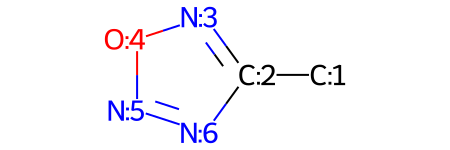

In [36]:
mol

In [37]:
from pprint import pprint
pprint (graph.edges())

(tensor([0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 1, 0, 1, 2, 3, 4, 5],
       dtype=torch.int32),
 tensor([1, 0, 2, 1, 3, 2, 4, 3, 5, 4, 1, 5, 0, 1, 2, 3, 4, 5],
       dtype=torch.int32))


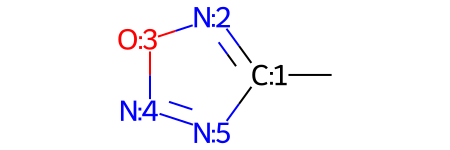

In [38]:
def remap(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol
remap(mol)

In [39]:
import torch
import torch.nn as nn
from dgllife.model import MPNNGNN

class GNNNet(nn.Module):
    def __init__(self,
                 node_in_feats = 74,
                 edge_in_feats = 13,
                 node_out_feats = 128,
                 edge_hidden_feats = 32,
                 num_step_message_passing = 3):
        super(GNNNet, self).__init__()
                
        self.mpnn = MPNNGNN(node_in_feats=node_in_feats,
                           node_out_feats=node_out_feats,
                           edge_in_feats=edge_in_feats,
                           edge_hidden_feats=edge_hidden_feats,
                           num_step_message_passing=num_step_message_passing)
        

    def forward(self, g, node_feats, edge_feats):
        atom_feats = self.mpnn(g, node_feats, edge_feats)

        return atom_feats
    
def predict(graph, net):
    node_feats = graph.ndata.pop('h')
    edge_feats = graph.edata.pop('e')
    return net(graph, node_feats, edge_feats)

In [40]:
net = GNNNet()
atom_feats = predict(graph, net)
print (atom_feats.size())

torch.Size([6, 128])


In [43]:
rsmi = '[C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8])[H:9]'
psmi = '[C:1]1([H:7])([H:8])/[C:2](=[N:3]\[H:9])[N:6]1[N:5]=[O:4]'
rmol = Chem.MolFromSmiles(rsmi)
pmol = Chem.MolFromSmiles(psmi)
rgraph = mol_to_bigraph(rmol, node_featurizer=node_featurizer, edge_featurizer=edge_featurizer, add_self_loop=True, canonical_atom_order=False)
pgraph = mol_to_bigraph(pmol, node_featurizer=node_featurizer, edge_featurizer=edge_featurizer, add_self_loop=True, canonical_atom_order=False)

In [44]:
net = GNNNet()
ratom_feats = predict(rgraph, net)
patom_feats = predict(pgraph, net)
diff_feats = patom_feats - ratom_feats
print (diff_feats.size())

RuntimeError: The size of tensor a (7) must match the size of tensor b (6) at non-singleton dimension 0

In [51]:
atom_p2r = {0: 0, 1: 1, 2: 2, 4: 5, 5: 4, 6: 3}
diff_feats = []
for pidx, ridx in atom_p2r.items():
    diff_feats.append(patom_feats[pidx]- ratom_feats[ridx])
diff_feats = torch.stack(diff_feats)
print (diff_feats.size())

torch.Size([6, 128])


In [62]:
def get_diff(ratom_feats, patom_feats, atom_p2r):
    diff_feats = []
    for pidx, ridx in atom_p2r.items():
        diff_feats.append(patom_feats[pidx]- ratom_feats[ridx])
    diff_feats = torch.stack(diff_feats)
    return diff_feats
diff_feats = get_diff(ratom_feats, patom_feats, atom_p2r)

In [63]:
linear = nn.Linear(128, 128)
diff_feats = linear(diff_feats)

In [65]:
ea_feats = torch.sum(diff_feats, dim = 0)

In [67]:
linear = nn.Linear(128, 1)
output = linear(ea_feats)
output

tensor([-0.1684], grad_fn=<AddBackward0>)

In [84]:
import torch
import torch.nn as nn
from dgllife.model import MPNNGNN

def get_diff(ratom_feats, patom_feats, atom_p2r):
    diff_feats = []
    for pidx, ridx in atom_p2r.items():
        diff_feats.append(patom_feats[pidx]- ratom_feats[ridx])
    diff_feats = torch.stack(diff_feats)
    return diff_feats

class GNNNet(nn.Module):
    def __init__(self,
                 node_in_feats = 74,
                 edge_in_feats = 13,
                 node_out_feats = 128,
                 edge_hidden_feats = 32,
                 num_step_message_passing = 3):
        super(GNNNet, self).__init__()
                
        self.mpnn = MPNNGNN(node_in_feats=node_in_feats,
                           node_out_feats=node_out_feats,
                           edge_in_feats=edge_in_feats,
                           edge_hidden_feats=edge_hidden_feats,
                           num_step_message_passing=num_step_message_passing)
        
        self.linear_diff = nn.Linear(node_out_feats, node_out_feats)
        self.linear_ea = nn.Linear(node_out_feats, 1)

    def forward(self, g, node_feats, edge_feats, atom_p2r):
        rg, pg = g
        rnode_feats, pnode_feats = node_feats
        redge_feats, pedge_feats = edge_feats
        
        ratom_feats = self.mpnn(rg, rnode_feats, redge_feats)
        patom_feats = self.mpnn(pg, pnode_feats, pedge_feats)
        diff_feats = get_diff(ratom_feats, patom_feats, atom_p2r)
        diff_feats = self.linear_diff(diff_feats)
        ea_feats = torch.sum(diff_feats, dim = 0)
        ea = self.linear_ea(ea_feats)
        return ea

In [90]:
def match_atomidx(rmol, pmol):
    atom_map2idx = {}
    atom_p2r = {}
    for atom in rmol.GetAtoms():
        if atom.GetSymbol() == 'H':
            continue
        atom_idx = atom.GetIdx()
        atom_map = atom.GetAtomMapNum()
        atom_map2idx[atom_map] = atom_idx
    for atom in pmol.GetAtoms():
        if atom.GetSymbol() == 'H':
            continue
        atom_idx = atom.GetIdx()
        atom_map = atom.GetAtomMapNum()
        atom_p2r[atom_idx] = atom_map2idx[atom_map]
    return atom_p2r

def predict(net, rsmi, psmi):
    rmol = Chem.MolFromSmiles(rsmi)
    pmol = Chem.MolFromSmiles(psmi)
    atom_p2r = match_atomidx(rmol, pmol)
    rgraph = mol_to_bigraph(rmol, node_featurizer=node_featurizer, edge_featurizer=edge_featurizer, add_self_loop=True, canonical_atom_order=False)
    pgraph = mol_to_bigraph(pmol, node_featurizer=node_featurizer, edge_featurizer=edge_featurizer, add_self_loop=True, canonical_atom_order=False)
    rnode_feats = rgraph.ndata.pop('h')
    redge_feats = rgraph.edata.pop('e')
    pnode_feats = pgraph.ndata.pop('h')
    pedge_feats = pgraph.edata.pop('e')
    return net((rgraph, pgraph), (rnode_feats, pnode_feats), (redge_feats, pedge_feats), atom_p2r)

In [91]:
net = GNNNet()
rsmi = '[C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8])[H:9]'
psmi = '[C:1]1([H:7])([H:8])/[C:2](=[N:3]\[H:9])[N:6]1[N:5]=[O:4]'
atom_p2r = {0: 0, 1: 1, 2: 2, 4: 5, 5: 4, 6: 3}
predict(net, rsmi, psmi)

tensor([-0.6140], grad_fn=<AddBackward0>)

In [94]:
ea = 77.6892865680395
criterion = nn.MSELoss()
output = predict(net, rsmi, psmi)
criterion(output, torch.FloatTensor([ea]))

tensor(6131.3970, grad_fn=<MseLossBackward0>)